In [17]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [18]:
# Setup paths for dataset
base_dir = 'dataset'  # Update this with the path to your dataset
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [19]:
# Define ImageDataGenerator for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# Load train and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 75000 images belonging to 5 classes.
Found 75000 images belonging to 5 classes.


Previewing training images:


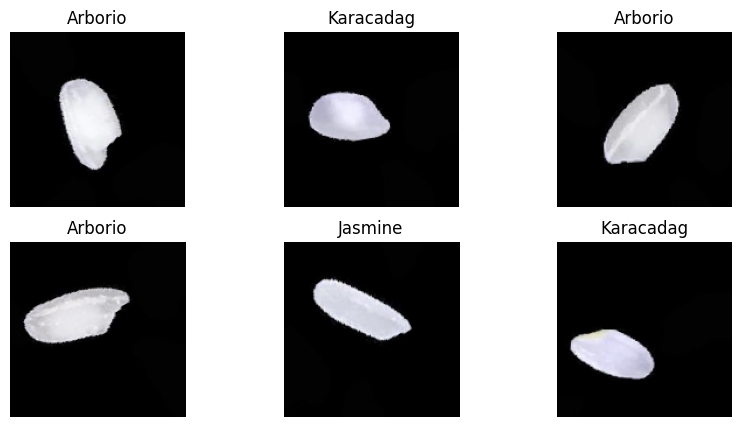

In [22]:
# Previewing the images of both the classes
def preview_images(generator):
    class_labels = ['Arborio', 'Basmati','Ispala','Jasmine','Karacadag']
    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        img, label = next(generator)
        plt.imshow(img[0])
        plt.title(class_labels[int(label[0])])
        plt.axis('off')
    plt.show()

print("Previewing training images:")
preview_images(train_generator)

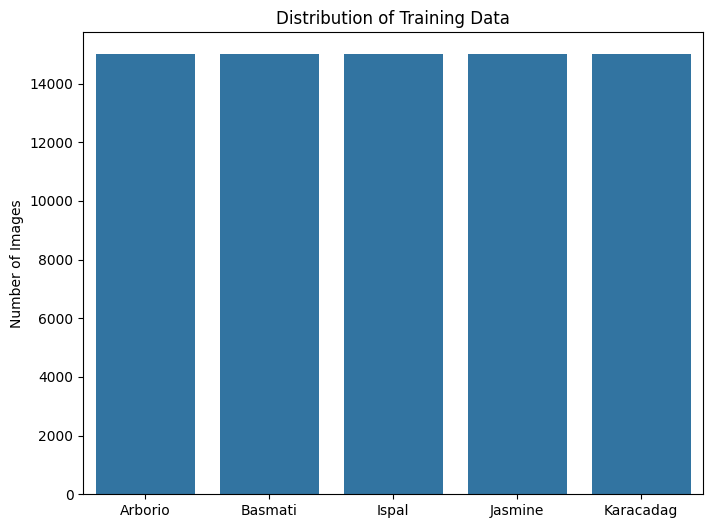

In [23]:
# Visualize data distribution
train_arborio_count = len(os.listdir(os.path.join(train_dir, 'Arborio')))
train_basmati_count = len(os.listdir(os.path.join(train_dir, 'Basmati')))
train_ipsala_count = len(os.listdir(os.path.join(train_dir, 'Ipsala')))
train_jasmine_count = len(os.listdir(os.path.join(train_dir, 'Jasmine')))
train_karacadag_count = len(os.listdir(os.path.join(train_dir, 'Karacadag')))

plt.figure(figsize=(8, 6))
sns.barplot(x=['Arborio', 'Basmati','Ispal','Jasmine','Karacadag'], y=[train_arborio_count, train_basmati_count, train_ipsala_count,train_jasmine_count, train_karacadag_count])
plt.title('Distribution of Training Data')
plt.ylabel('Number of Images')
plt.show()

In [24]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Python3.10\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=2,
    callbacks=[early_stopping]
)

Epoch 1/2
   9/2343 ━━━━━━━━━━━━━━━━━━━━ 26:17 676ms/step - accuracy: 0.2244 - loss: -25973917801775104.0000

KeyboardInterrupt: 

NameError: name 'history' is not defined

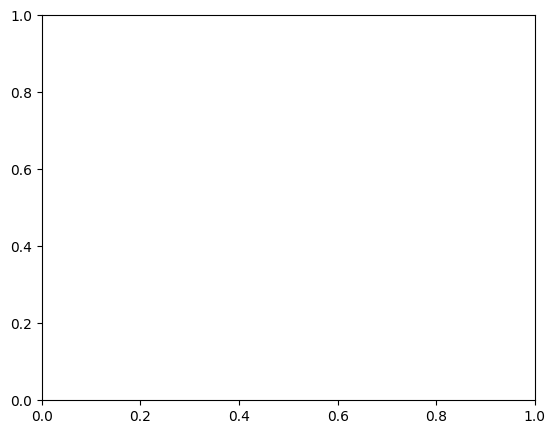

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

NameError: name 'history' is not defined

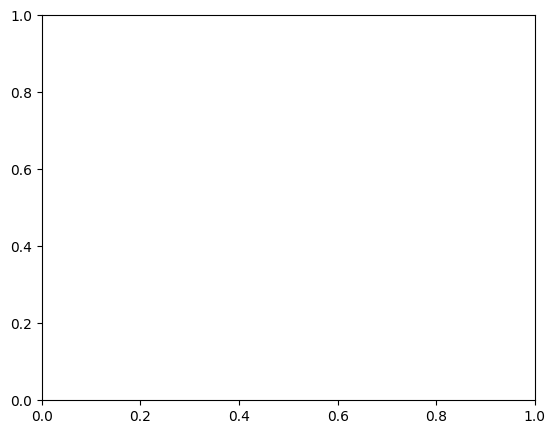

In [16]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_acc:.2f}')

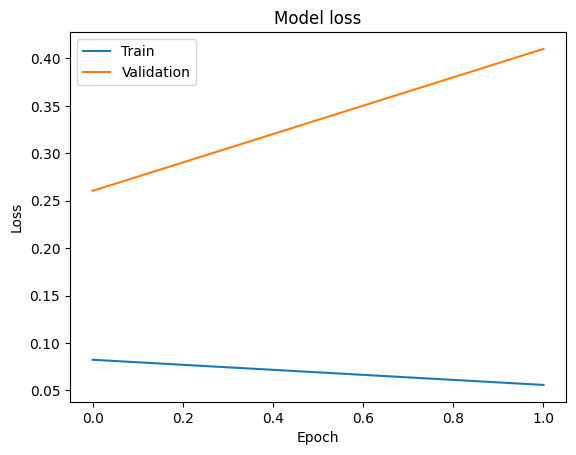

In [55]:
# Classification report and confusion matrix
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
y_pred = np.round(Y_pred).astype(int)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=['Normal', 'Pneumonia']))

print('Confusion Matrix')
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [56]:
# Save the model
model.save('Model/rice_classifier.h5')